In [1]:
from matplotlib.pyplot import imshow
import matplotlib.cm as cm
import matplotlib.pylab as plt
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import PIL
from PIL import ImageFilter
import cv2
import itertools
import random
import keras
from keras import utils as np_utils
import tensorflow as tf
import imutils
from imutils import paths
import os
from keras import optimizers
from keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras import callbacks
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D , UpSampling2D ,Conv2DTranspose, Conv1D, MaxPooling1D, UpSampling1D
from keras import backend as K
import pandas as pd
# %matplotlib inline

In [2]:
def pil_image(img_path):
    pil_im =PIL.Image.open(img_path).convert('L')
    pil_im=pil_im.resize((105,105))
    #imshow(np.asarray(pil_im))
    
    return pil_im

# Augumentation Steps
1) Noise 2) Blur 3) Perpective Rotation 4) Shading 5) Variable Character Spacing 6) Variable Aspect Ratio

In [3]:
def noise_image(pil_im):
    # Adding Noise to image
    img_array = np.asarray(pil_im)
    mean = 0.0   # some constant
    std = 5   # some constant (standard deviation)
    noisy_img = img_array + np.random.normal(mean, std, img_array.shape)
    noisy_img_clipped = np.clip(noisy_img, 0, 255)
    noise_img = PIL.Image.fromarray(np.uint8(noisy_img_clipped)) # output
    #imshow((noisy_img_clipped ).astype(np.uint8))
    noise_img=noise_img.resize((105,105))
    return noise_img


In [4]:
def blur_image(pil_im):
    #Adding Blur to image 
    blur_img = pil_im.filter(ImageFilter.GaussianBlur(radius=3)) # ouput
    #imshow(blur_img)
    blur_img=blur_img.resize((105,105))
    return blur_img

In [5]:
def affine_rotation(img):
    
    #img=cv2.imread(img_path,0)
    rows, columns = img.shape

    point1 = np.float32([[10, 10], [30, 10], [10, 30]])
    point2 = np.float32([[20, 15], [40, 10], [20, 40]])

    A = cv2.getAffineTransform(point1, point2)

    output = cv2.warpAffine(img, A, (columns, rows))
    affine_img = PIL.Image.fromarray(np.uint8(output)) # affine rotated output
    #imshow(output)
    affine_img=affine_img.resize((105,105))
    return affine_img

In [6]:
def gradient_fill(image):
    #image=cv2.imread(img_path,0)
    laplacian = cv2.Laplacian(image,cv2.CV_64F)
    laplacian = cv2.resize(laplacian, (105, 105))
    return laplacian

# Preparing Dataset

In [7]:
data_path = "Train"
data=[]
labels=[]
imagePaths = sorted(list(paths.list_images(data_path)))
random.seed(42)
random.shuffle(imagePaths)

In [8]:
def conv_label(label):
    if label == 'Potato___Early_blight':
        return 0
    elif label == 'Potato___healthy':
        return 1
    elif label == 'Potato___Late_blight':
        return 2

In [9]:
augument=["blur","noise","affine","gradient"]
a=itertools.combinations(augument, 4)

for i in list(a): 
    print(list(i))

print(len(imagePaths))

['blur', 'noise', 'affine', 'gradient']
900


In [10]:
imagePaths[0].split(os.path.sep)[-2]

'Potato___Early_blight'

In [11]:
counter=0
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    label = conv_label(label)
    #print(label)
    pil_img = pil_image(imagePath)
    #imshow(pil_img)
    
    # Adding original image
    org_img = img_to_array(pil_img)
    #print(org_img.shape)
    data.append(org_img)
    labels.append(label)
    
    augument=["noise","blur","affine","gradient"]
    for l in range(0,len(augument)):
    
        a=itertools.combinations(augument, l+1)

        for i in list(a): 
            combinations=list(i)
            #print(len(combinations))
            temp_img = pil_img
            for j in combinations:
            
                if j == 'noise':
                    # Adding Noise image
                    temp_img = noise_image(temp_img)
                    
                elif j == 'blur':
                    # Adding Blur image
                    temp_img = blur_image(temp_img)
                    #imshow(blur_img)
                    
    
                elif j == 'affine':
                    open_cv_affine = np.array(pil_img)
                    # Adding affine rotation image
                    temp_img = affine_rotation(open_cv_affine)

                elif j == 'gradient':
                    open_cv_gradient = np.array(pil_img)
                    # Adding gradient image
                    temp_img = gradient_fill(open_cv_gradient)
  
            temp_img = img_to_array(temp_img)
            data.append(temp_img)
            labels.append(label)

print(len(data))

14400


In [12]:
data = np.asarray(data, dtype="int") / 255.0
labels = np.array(labels)
print("Success")

Success


In [13]:
labels

array([0, 0, 0, ..., 1, 1, 1])

In [14]:
#train_test_split(data,labels, test_size=float("0.25"), random_state=int("42"))

In [15]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) =  train_test_split(data,labels, test_size=0.2, random_state=42)
# convert the labels from integers to vectors
try:
    trainY = to_categorical(trainY, num_classes=7) ## input of to_categorial is class vector of integers
    print(trainY)
except Exception as ex:
    trainY = None
    print(ex)
try:
    testY = to_categorical(testY, num_classes=7)
    print(testY)
except Exception as ex:
    testY = None
    print(ex)

[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


In [16]:
trainX.shape, testX.shape, trainY.shape, testY.shape

((11520, 105, 105, 1), (2880, 105, 105, 1), (11520, 7), (2880, 7))

In [17]:
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,horizontal_flip=True)

In [18]:
K.image_data_format()

'channels_last'

In [19]:
def conv_label(label):
    if label == 'Potato___Early_blight':
        return 0
    elif label == 'Potato___healthy':
        return 1
    elif label == 'Potato___Late_blight':
        return 2

# LPQ Feature calculation

In [20]:
# coding: utf-8
import numpy as np
from scipy.signal import convolve2d

class LPQ(object):
    """ This implementation of Local Phase Quantization (LPQ) is a 
      
      Reference: 
        Ojansivu V & Heikkilä J (2008) Blur insensitive texture classification 
        using local phase quantization. Proc. Image and Signal Processing 
	(ICISP 2008), Cherbourg-Octeville, France, 5099:236-243.
        Copyright 2008 by Heikkilä & Ojansivu
    """

    def __init__(self, radius=3):
        self.radius = radius

    def euc_dist(self, X):
        Y = X = X.astype(np.float)
        XX = np.sum(X * X, axis=1)[:, np.newaxis]
        YY = XX.T
        distances = np.dot(X,Y.T)
        distances *= -2
        distances += XX
        distances += YY
        np.maximum(distances, 0, distances)
        distances.flat[::distances.shape[0] + 1] = 0.0
        return np.sqrt(distances)

    def __call__(self,X):
        f = 1.0
        x = np.arange(-self.radius,self.radius+1)
        n = len(x)
        rho = 0.95
        [xp, yp] = np.meshgrid(np.arange(1,(n+1)),np.arange(1,(n+1)))
        pp = np.concatenate((xp,yp)).reshape(2,-1)
        dd = self.euc_dist(pp.T) # squareform(pdist(...)) would do the job, too...
        C = np.power(rho,dd)

        w0 = (x*0.0+1.0)
        w1 = np.exp(-2*np.pi*1j*x*f/n)
        w2 = np.conj(w1)

        q1 = w0.reshape(-1,1)*w1
        q2 = w1.reshape(-1,1)*w0
        q3 = w1.reshape(-1,1)*w1
        q4 = w1.reshape(-1,1)*w2

        u1 = np.real(q1)
        u2 = np.imag(q1)
        u3 = np.real(q2)
        u4 = np.imag(q2)
        u5 = np.real(q3)
        u6 = np.imag(q3)
        u7 = np.real(q4)
        u8 = np.imag(q4)

        M = np.matrix([u1.flatten(), u2.flatten(), u3.flatten(), u4.flatten(), u5.flatten(), u6.flatten(), u7.flatten(), u8.flatten()])

        D = np.dot(np.dot(M,C), M.T)
        U,S,V = np.linalg.svd(D)

        Qa = convolve2d(convolve2d(X,w0.reshape(-1,1),mode='same'),w1.reshape(1,-1),mode='same')
        Qb = convolve2d(convolve2d(X,w1.reshape(-1,1),mode='same'),w0.reshape(1,-1),mode='same')
        Qc = convolve2d(convolve2d(X,w1.reshape(-1,1),mode='same'),w1.reshape(1,-1),mode='same')
        Qd = convolve2d(convolve2d(X, w1.reshape(-1,1),mode='same'),w2.reshape(1,-1),mode='same')

        Fa = np.real(Qa)
        Ga = np.imag(Qa)
        Fb = np.real(Qb) 
        Gb = np.imag(Qb)
        Fc = np.real(Qc) 
        Gc = np.imag(Qc)
        Fd = np.real(Qd) 
        Gd = np.imag(Qd)

        F = np.array([Fa.flatten(), Ga.flatten(), Fb.flatten(), Gb.flatten(), Fc.flatten(), Gc.flatten(), Fd.flatten(), Gd.flatten()])
        G = np.dot(V.T, F)

        t = 0

        # Calculate the LPQ Patterns:
        B = (G[0,:]>=t)*1 + (G[1,:]>=t)*2 + (G[2,:]>=t)*4 + (G[3,:]>=t)*8 + (G[4,:]>=t)*16 + (G[5,:]>=t)*32 + (G[6,:]>=t)*64 + (G[7,:]>=t)*128
        B = np.reshape(B, np.shape(Fa))

        # And finally build the histogram:
        h, b  = np.histogram(B, bins=256, range = (0,255))

        return h

    def __repr__(self):
        return "LPQ (radius=%s)" % (self.radius)

#len(trainX)
#
#trainX.shape

lpq = LPQ(3)

#lpq

# calculate training LPQ features

In [21]:
dim = (trainX.shape[1],trainX.shape[1])

train_feat =[]

for i in range(len(trainX)):
    X = trainX[i]
    X = X.reshape(dim)
    lpq_feat = lpq(X)
    train_feat.append(lpq_feat)

print(len(train_feat))

#train_feat[0]

train_feat = np.array(train_feat)

print(train_feat.shape)


C:\Users\Hira\AppData\Local\Temp/ipykernel_4796/1640420042.py:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y = X = X.astype(np.float)


11520
(11520, 256)


# calculate testing LPQ features

In [22]:
dim = (testX.shape[1],testX.shape[1])
#dim

test_feat =[]

for i in range(len(testX)):
    X= testX[i]
    X = X.reshape(dim)
    lpq_feat = lpq(X)
    test_feat.append(lpq_feat)

test_feat = np.array(test_feat)

print(test_feat.shape)

numTrain = int(pd.to_numeric(trainX.shape[0]))
print(numTrain)

numTest = int(pd.to_numeric(testX.shape[0]))
print(numTest)

C:\Users\Hira\AppData\Local\Temp/ipykernel_4796/1640420042.py:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y = X = X.astype(np.float)


(2880, 256)
11520
2880


# Create model that work on LPQ features

In [23]:
test_feat.shape, train_feat.shape, testX.shape, trainX.shape

((2880, 256), (11520, 256), (2880, 105, 105, 1), (11520, 105, 105, 1))

In [24]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=12, input_shape=(256,1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(64, kernel_size=24, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

In [25]:
#Cs Layers
model.add(Conv1D(256, kernel_size=12, activation='relu'))

model.add(Conv1D(256, kernel_size=12, activation='relu'))

model.add(Conv1D(256, kernel_size=12, activation='relu'))

model.add(Flatten())

model.add(Dense(4096, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(4096,activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(2383,activation='relu'))
model.add(Dropout(0.5))

#model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(7, activation='softmax'))

# reshaping LPQ training and testing features according to input of CNN here 256 is no of features per image

In [26]:
train_feat = train_feat.reshape((len(train_feat),256,1))
test_feat = test_feat.reshape((len(test_feat),256,1))
batch_size = 16
epochs = 25
sgd = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

early_stopping=callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min')

C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


# file path where the model weights will be stored

In [27]:
filepath="top_model.h5"

checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

callbacks_list = [early_stopping,checkpoint]

print(model.summary())

history = model.fit(train_feat, trainY,shuffle=True,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(test_feat, testY),callbacks=callbacks_list)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 245, 32)           416       
                                                                 
 batch_normalization (BatchN  (None, 245, 32)          128       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 122, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 99, 64)            49216     
                                                                 
 batch_normalization_1 (Batc  (None, 99, 64)           256       
 hNormalization)                                                 
                                                        

Epoch 18/25
720/720 [==============================] - ETA: 0s - loss: 0.0015 - accuracy: 0.9937
Epoch 18: val_loss improved from 0.00673 to 0.00559, saving model to top_model.h5
720/720 [==============================] - 316s 438ms/step - loss: 0.0015 - accuracy: 0.9937 - val_loss: 0.0056 - val_accuracy: 0.9760
Epoch 19/25
720/720 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 0.9928
Epoch 19: val_loss did not improve from 0.00559
720/720 [==============================] - 350s 485ms/step - loss: 0.0017 - accuracy: 0.9928 - val_loss: 0.0075 - val_accuracy: 0.9701
Epoch 20/25
720/720 [==============================] - ETA: 0s - loss: 0.0018 - accuracy: 0.9924
Epoch 20: val_loss did not improve from 0.00559
720/720 [==============================] - 353s 490ms/step - loss: 0.0018 - accuracy: 0.9924 - val_loss: 0.0073 - val_accuracy: 0.9698
Epoch 21/25
720/720 [==============================] - ETA: 0s - loss: 0.0021 - accuracy: 0.9911
Epoch 21: val_loss did not im

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


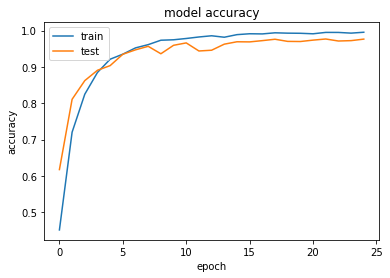

In [28]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

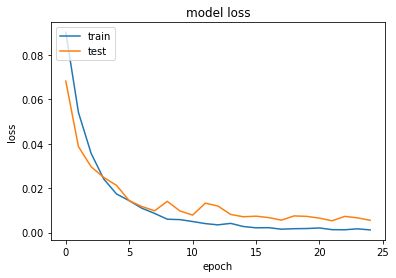

Test loss: 0.0055152541026473045
Test accuracy: 0.9763888716697693
Test loss: 0.005304320715367794
Test accuracy: 0.9767361283302307


In [29]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

score = model.evaluate(test_feat, testY, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

from keras.models import load_model
model = load_model('top_model.h5')

score = model.evaluate(test_feat, testY, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [36]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

  #Add Normalization Option
  #prints pretty confusion metric with normalization option
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')

  # print(cm)
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


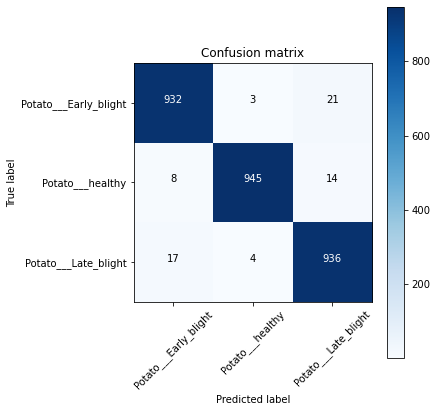

In [42]:
from sklearn.metrics import classification_report, confusion_matrix
predict_x=model.predict(test_feat) 
classes_x=np.argmax(predict_x,axis=1)
p1=[]
for i in range(0,len(testY)):
    for j in range(0,3):
        if(testY[i][j]==1):
            p1.append(j)

cm = confusion_matrix(classes_x, p1)
classes = ['Potato___Early_blight','Potato___healthy','Potato___Late_blight']
plot_confusion_matrix(cm,classes)

In [38]:
from sklearn.metrics import precision_score, classification_report, recall_score, f1_score

In [39]:
# 'micro', 'macro', 'weighted'
precision = precision_score(classes_x, p1, average='micro')
print('Precision: %.3f' % precision)

Precision: 0.977


In [40]:
recall = recall_score(classes_x, p1, average='micro')
print('Precision: %.3f' % recall)

Precision: 0.977


In [41]:
f1 = f1_score(classes_x, p1, average='micro')
print('Precision: %.3f' % f1)

Precision: 0.977
